In [4]:
import quaternion as q
import numpy as np
import pykitti
import matplotlib.pyplot as plt
import os

In [5]:
directoryL = os.path.join('..', '..', 'dataset')
list_Y = [],[]
#for i in range(11):
i = 0
data = pykitti.odometry(directoryL, str(i).zfill(2))
data.load_poses()

#Empty arrays to hold data
Translations = np.zeros((len(data.T_w_cam0),3))
Quaternions = np.zeros(len(data.T_w_cam0), dtype=q.quaternion)

#store quaternions and translations
for j in range(len(data.T_w_cam0)):
    Translations[j,:] = data.T_w_cam0[j][:-1,-1]
    Quaternions[j] = (q.from_rotation_matrix(data.T_w_cam0[j][:-1,:-1])).normalized()

# Make empty arrays to hold data
delta_trans = np.zeros((len(data.T_w_cam0),3))
corrected_delta_trans = np.zeros((len(data.T_w_cam0),3))
delta_quat = np.zeros(len(data.T_w_cam0),dtype=q.quaternion)

#Get translations between frames
delta_trans[:-1,:] = Translations[1:,:]-Translations[:-1,:]

#Correct translations to provide relative motion from car's perspective
for k in range(len(delta_trans)-1):
    corrected_delta_trans[k] = (Quaternions[k]*q.quaternion(0.,*delta_trans[k])*Quaternions[k].conj()).vec

#get rotations between frames

delta_quat[:-1] = Quaternions[1:]/Quaternions[:-1]

list_Y[0].append(corrected_delta_trans[:-1])
list_Y[1].append(delta_quat[:-i])

Loading poses for sequence 00...
done.


In [6]:
print(list_Y[0][0])

[[-0.04690294 -0.02839928  0.8586941 ]
 [-0.04862792 -0.02932692  0.85744892]
 [-0.05047635 -0.03032919  0.85842007]
 ..., 
 [-0.1063143  -0.02032201  1.12932902]
 [-0.1061058  -0.03678786  1.12273182]
 [-0.11241985 -0.04929353  1.12942258]]


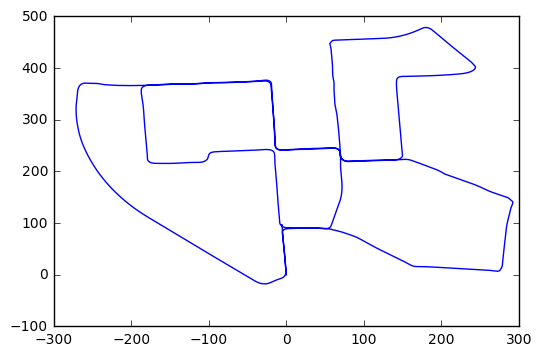

In [7]:
plt.plot(Translations[:,0],Translations[:,2])
plt.show()

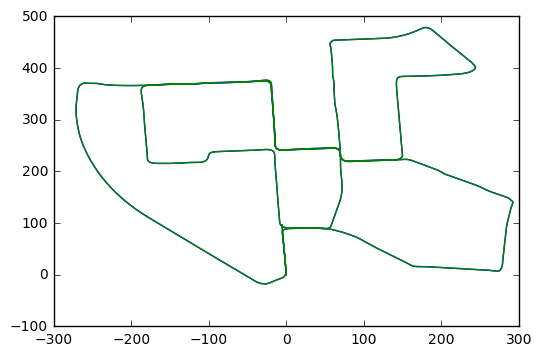

In [8]:
accumulated = np.zeros((delta_trans.shape[0],3))
for i in range(delta_trans.shape[0]):
    accumulated[i,:] = np.sum(delta_trans[:i], axis=0)
plt.plot(Translations[:,0],Translations[:,2])
plt.plot(accumulated[:,0], accumulated[:,2])
plt.show()

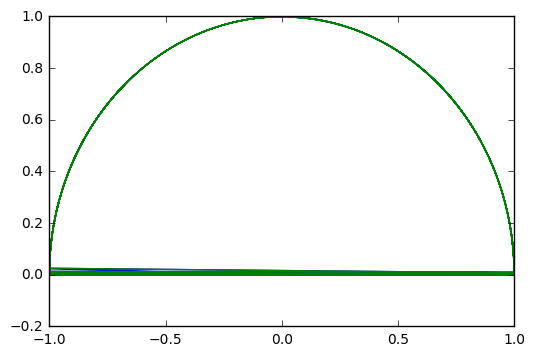

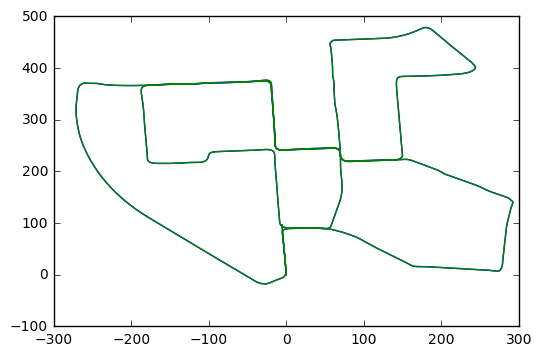

In [9]:
#Test rotations

#Undo rotation delta
quat_test = np.zeros(len(Quaternions), dtype=q.quaternion)
quat_test[0] = Quaternions[0]
for j in range(quat_test.shape[0]-2):
    quat_test[j+1] = delta_quat[j]*quat_test[j]
plt.plot(q.as_float_array(quat_test)[:,0], q.as_float_array(quat_test)[:,2])
plt.plot(q.as_float_array(Quaternions)[:,0], q.as_float_array(Quaternions)[:,2])
plt.show()

# Undo rotation on translation deltas
uncorrected_delta_trans = np.zeros((len(data.T_w_cam0),3))
for k in range(len(delta_trans)-1):
    uncorrected_delta_trans[k] = (quat_test[k].conj()*q.quaternion(0.,*corrected_delta_trans[k])*quat_test[k]).vec

#Get final translation data
accumulated_2 = np.zeros((uncorrected_delta_trans.shape[0],3))
for i in range(uncorrected_delta_trans.shape[0]):
    accumulated_2[i,:] = np.sum(uncorrected_delta_trans[:i], axis=0)
plt.plot(accumulated_2[:,0], accumulated_2[:,2])
plt.plot(accumulated[:,0], accumulated[:,2])
plt.show()
